In [1]:
#mini batch, dropout, learning rate
import sys, numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
images = x_train[0:1]
labels = y_train[0:1]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(images)
print(labels)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126
   136 175  26 166 255 247 127   0   0   0   0]
  [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253
   253 225 172 253 242 195  64   0   0   0   0]
  [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253
   251  93  82  82  56  39   0   0   0   0   0

In [3]:
def preprocess(x_input, y_labels, num_labels=10):
        
    #Normalizing the value of image pixels
    x_result = x_input/255.0
    # We need one hot encoded label for our task
    ohe_labels = np.zeros((len(y_labels), num_labels))
    for index, label in enumerate(y_labels):
        ohe_labels[index][label] = 1 # rest all the value except the one indexed by label will be 0
    return x_result, ohe_labels

def flatten(x_input):
    # Flatten the input and one_hot encode labels        
    idx = 0
    flat_dim = 1
    # Multiplying all of the dimensions of input except for first one which represents count to flatten
    for i in x_input.shape:
        if idx > 0:
            flat_dim *= i
        idx += 1
    x_result = x_input.reshape(x_input.shape[0], flat_dim)
    return x_result

In [4]:
toy_xtrain  = x_train[0:1000]
toy_ytrain  = y_train[0:1000]
print(toy_xtrain.shape)
print(toy_ytrain.shape)

toy_xtrain, toy_ytrain = preprocess(toy_xtrain, toy_ytrain)
x_train, y_train = preprocess(x_train, y_train)
x_test, y_test = preprocess(x_test, y_test)
# print(toy_xtrain.shape)
# print(toy_ytrain.shape)

(1000, 28, 28)
(1000,)


In [5]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [6]:
# reshaping input for data augmentation
toy_xtrain = toy_xtrain.reshape(-1,28,28,1)
x_train = x_train.reshape(-1,28,28,1)
datagen.fit(toy_xtrain)

## With Dropout (in model class), Minibatch and learning rate

In [7]:
# Linear Layer
class Linear:
    def __init__(self, input_dim, num_neurons):
        # Xavier's Initialization of weights
        self.weights = np.random.randn(input_dim, num_neurons) * np.sqrt(2/input_dim)
        self.bias = np.zeros(1)

    def __call__(self, x):
        self.x = x
        output = x @ self.weights + self.bias
#         print(f'Linear layer output shape {output.shape}')
        return output
    
    def backprop_gradient(self, gradient):
        # Here we are computing the gradient with which we need to adjust the weight and bias of this layer
        # using the gradient from the layer after this, and we also compute the x-gradient (the gradient with which
        # the previous layer's output needs to adjust which will get returned)
        
        # y = wx + b
        # x-gradient    dy/dx = w
        # w-gradient    dy/dw = x
        # bias gradient dy/db = 1
        #(300, 3)(3, 3)(300, 1)
        self.w_gradient = self.x.T @ gradient
        self.x_gradient = gradient @ self.weights.T
        self.bias_gradient = gradient.sum()
        return self.x_gradient
    
    def update(self, lr):
        # Updating weights and bias value calculated in backprop function
        self.weights = self.weights - lr * self.w_gradient
        self.bias = self.bias - lr * self.bias_gradient
        
        

class Relu:
    def __call__(self, input):
        self.input = input
        self.output = np.clip(self.input, 0, None)
        return self.output
    
    def backprop_gradient(self, gradient):
        self.input_gradient = (self.input > 0) * gradient
        return self.input_gradient

    
class SoftMax:
    #https://stackoverflow.com/questions/54880369/implementation-of-softmax-function-returns-nan-for-high-inputs
    def __call__(self, input):
        self.input = input
        exp_i = np.exp(input - np.max(input))
        self.output = exp_i / exp_i.sum(axis=0, keepdims=True)
        return self.output
    
    def backprop_gradient(self, gradient):
        #https://themaverickmeerkat.com/2019-10-23-Softmax/
        n = self.input.shape[1]
        t1 = np.einsum('ij,ik->ijk', self.output, self.output)
        t2 = np.einsum('ij,jk->ijk', self.output, np.eye(n,n))
        deriv_softmax = t2 - t1
        #multiplying the gradients
        self.input_gradient = np.einsum('ijk,ik->ij', deriv_softmax, gradient)
        return self.input_gradient
        

class CrossEntropy:
    
    def __call__(self, y_true, y_pred):
#         print(y_true[0])
#         print(y_pred[0])
        self.y_pred = y_pred
        self.y_true = y_true
        N = y_true.shape[0] #Number of predictions (same as number of corresponding labels)
        return (-np.sum(y_true * np.log(y_pred+1e-9)))/N
    
    def backprop_gradient(self):
        return -self.y_true/(self.y_pred+1e-9)
        
        

    
class MSE:
    def __call__(self, y_true, y_pred):
        self.y_pred = y_pred
        self.y_true = y_true
        # MSE = (delta_y1^2/n + delta_y2^2/n + ...delta_yn^2/n)
        return ((self.y_pred - self.y_true)**2).mean()
    
    def backprop_gradient(self):
        # At this level we want to find out what effect the predicted value has on the cost function,
        #or in other words how much sensitive a cost function is to small change in predicted output,
        # which translates mathematically as finding the derivative of cost function with respect to predicted output
        n = self.y_true.shape[0]
        #derivative of MSE wrt output delta_y = 2*(delta_y1 + delta_y2 + ...)/n
        self.gradient = 2 * (self.y_pred - self.y_true)/n
#         print(f'MSE Backward_Gradient ==> Y_shape {self.y_pred.shape} gradient_shape {self.gradient.shape}')
        return self.gradient
        
        
    
    
class Model:
    
    def __init__(self, input_dim):
        self.linear1 = Linear(input_dim, 50)
        self.relu1   = Relu()
        self.linear2 = Linear(50, 25)
        self.relu2   = Relu()
        self.linear3 = Linear(25, 16)
        self.relu3   = Relu()
        self.linear4 = Linear(16,10)
#         self.softmax = SoftMax()
        
    def __call__(self, x, train = True):
        l1 = self.linear1(x)
#         print(f'l1 ==> {l1.shape}')
        r1 = self.relu1(l1)
#         print(f'r1 ==> {r1.shape}')
        l2 = self.linear2(r1)
#         print(f'l2 ==> {l2.shape}')
        r2 = self.relu2(l2)
        if train:
            self.drop2 = np.random.randint(2,size=r2.shape)
            r2 *= self.drop2 * 2
#         print(f'r2 ==> {r2.shape}')
        l3 = self.linear3(r2)
        r3 = self.relu3(l3)
        l4 = self.linear4(r3)
        
#         print(f'l3 ==> {l3.shape}')
#         sm1 = self.softmax(l3)
#         print(f'sm1 ==> {sm1.shape}')
        return l4
    
    def backward(self, op_gradient):
#         sm_gradient = self.softmax.backprop_gradient(op_gradient)
        l4_gradient = self.linear4.backprop_gradient(op_gradient)
        r3_gradient = self.relu3.backprop_gradient(l4_gradient)
        l3_gradient = self.linear3.backprop_gradient(r3_gradient)
        r2_gradient = self.relu2.backprop_gradient(l3_gradient)
        r2_gradient *= self.drop2
        l2_gradient = self.linear2.backprop_gradient(r2_gradient)
        r1_gradient = self.relu1.backprop_gradient(l2_gradient)
        l1_gradient = self.linear1.backprop_gradient(r1_gradient)
        return l1_gradient
    
    def update(self, lr):
        self.linear4.update(lr)
        self.linear3.update(lr)
        self.linear2.update(lr)
        self.linear1.update(lr)
        
        
    

In [8]:
flat_test_x = flatten(x_test)

def fit(x, y_true, model, loss, lr=.03, num_epoch=5000, batch_size=10):
    
    for epoch in range(num_epoch):
        
        i = 0
        for x_batch,y_batch in datagen.flow(x, y_true, 10):
            if(i > 10):
                break
            flat_x = flatten(x_batch)
            batch_y_pred = model(flat_x)
            loss_val = loss(y_batch, batch_y_pred)
#             print(f'Epoch {epoch}, train loss {loss_val}')
            model.backward(loss.backprop_gradient())
            model.update(lr)
            i += 1
            
        if(epoch % 100 == 0):
            err = 0.0
            count = 0

            test_y_pred = model(flat_test_x, False)
            loss_val = loss(y_test, test_y_pred)
            for i in range(len(flat_test_x)):
                count += int(np.argmax(test_y_pred[i:i+1]) == np.argmax(y_test[i:i+1]))
            acc = count/len(flat_test_x)
            print(f'test acc {acc}, test loss {loss_val}')
                

In [9]:
mse = MSE()
model = Model(784)
fit(toy_xtrain, toy_ytrain, model, mse, batch_size=10)

test acc 0.0661, test loss 0.08980295470331352
test acc 0.098, test loss 0.08997918468815605
test acc 0.098, test loss 0.08927778425838294
test acc 0.0982, test loss 0.08550139666511349
test acc 0.133, test loss 0.083985957641933
test acc 0.1809, test loss 0.08231725661944521
test acc 0.3216, test loss 0.07812223707545336
test acc 0.42, test loss 0.06962234677757756
test acc 0.4757, test loss 0.06509829696825205
test acc 0.4877, test loss 0.0622341795673318
test acc 0.4939, test loss 0.06271423099026455
test acc 0.4958, test loss 0.061720010544883123
test acc 0.5014, test loss 0.061065740054807596
test acc 0.4968, test loss 0.05937954713195081
test acc 0.4929, test loss 0.06097928058570267
test acc 0.5025, test loss 0.06021836001223203
test acc 0.5051, test loss 0.05985729461662357
test acc 0.5082, test loss 0.05996075841508783
test acc 0.5125, test loss 0.06165747832300995
test acc 0.5288, test loss 0.060395103405270774
test acc 0.5402, test loss 0.06005400441059558
test acc 0.5417, t

In [14]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
test_y_pred = model(flat_test_x, False)
# int(np.argmax(test_y_pred[i:i+1]) == np.argmax(y_test[i:i+1]))
y_pred = []
y_true = []
for i in range(len(flat_test_x)):
    y_pred.append(np.argmax(test_y_pred[i:i+1]))
    y_true.append(np.argmax(y_test[i:i+1]))

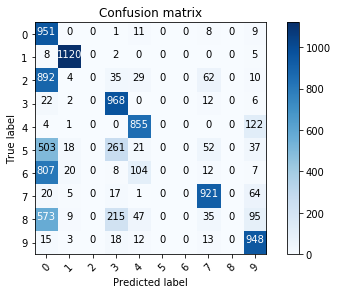

In [20]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(10))